In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join
import json
import h5py
import pprint
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

from utils.io import load_json, save_json

#### Fix seed

In [3]:
np.random.seed(0)

### Load data file

In [4]:
# set data root
data_root = "/var/scratch/pbagad/datasets/howto100m/"

# # load annotations
# annotations = load_json(join(data_root, "caption.json"))

In [5]:
df = pd.read_csv(join(data_root, "HowTo100M_v1.csv"))

In [6]:
df.shape

(1238911, 5)

In [7]:
df.columns

Index(['video_id', 'category_1', 'category_2', 'rank', 'task_id'], dtype='object')

In [8]:
df

,video_id,category_1,category_2,rank,task_id
0,nVbIUDjzWY4,Cars & Other Vehicles,Motorcycles,27,52907
1,CTPAZ2euJ2Q,Cars & Other Vehicles,Motorcycles,35,109057
2,rwmt7Cbuvfs,Cars & Other Vehicles,Motorcycles,99,52907
3,HnTLh99gcxY,Cars & Other Vehicles,Motorcycles,35,52907
4,EyP3HVhg1u0,Cars & Other Vehicles,Motorcycles,95,52906
...,...,...,...,...,...
1238906,tVc0qvCeVfQ,Hobbies and Crafts,Crafts,41,38941
1238907,gIURSGIXX0Y,Hobbies and Crafts,Crafts,11,37466
1238908,gHTVgMEpR2Q,Food and Entertaining,Recipes,1,101069
1238909,_97kyZVWVG0,Hobbies and Crafts,Crafts,34,119814


In [9]:
task_df = pd.read_csv(join(data_root, "task_ids.csv"), delimiter="\t", header=None)

In [10]:
len(task_df)

123520

### Select subset to download

In [11]:
len(df.category_1.unique()), len(df.category_2.unique())

(20, 143)

In [12]:
len(df.task_id.unique())

25312

In [13]:
print("Number of tasks with > 1k videos each: ", sum(df.task_id.value_counts() > 100))

Number of tasks with > 1k videos each:  1138


In [14]:
len(df.task_id.unique()), len(task_df[0].unique()), set(df.task_id.unique()).issubset(set(task_df[0].unique()))

(25312, 123520, True)

In [15]:
# get tasks with > 100 videos
s = (df.task_id.value_counts() > 100)
populous_tasks = s[s].index.values

In [16]:
K = 1000

# select K tasks
selected_task_ids = sorted(np.random.choice(populous_tasks, K, replace=False))

# select N videos per task
N = 100

In [17]:
# selected_video_ids = []
selected_indices = []

for task_id in selected_task_ids:
    rows = df[df.task_id.isin([task_id])]
    selected_indices_k = np.random.choice(rows.index, N, replace=False)
    # video_ids = rows.video_id
    # selected_video_ids_k = np.random.choice(video_ids, N, replace=False)
    selected_indices.extend(selected_indices_k)
    # break
selected_indices = sorted(selected_indices)

In [18]:
len(selected_indices)

100000

In [19]:
subdf = df[df.index.isin(selected_indices)]

In [20]:
subdf.shape

(100000, 5)

In [21]:
subdf["original_index"] = subdf.index.copy()
subdf.set_index(pd.Series(np.arange(len(subdf))), inplace=True)

/tmp/ipykernel_3089747/1984947929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf["original_index"] = subdf.index.copy()


In [22]:
subdf

,video_id,category_1,category_2,rank,task_id,original_index
0,sPevb2NYGzg,Cars & Other Vehicles,Motorcycles,114,17548,39
1,S3ZdC7EcfMs,Cars & Other Vehicles,Motorcycles,9,89240,59
2,SPLBLFqPMoA,Food and Entertaining,Recipes,132,99751,91
3,ohf6NGQtD-0,Family Life,Parenting,148,16001,350
4,Bspn6RepEVk,Family Life,Parenting,155,16001,353
...,...,...,...,...,...,...
99995,7Ml7hinhbRI,Cars & Other Vehicles,Boats,76,8534,1238516
99996,LBaSWl8ZEpw,Cars & Other Vehicles,Cars,38,95134,1238626
99997,H9iBp6XSchc,Cars & Other Vehicles,Cars,7,95134,1238627
99998,MESXtTwvQ2c,Cars & Other Vehicles,Cars,22,95134,1238628


In [23]:
split_dir = join(data_root, "subsets")
os.makedirs(split_dir, exist_ok=True)

split_path = join(split_dir, "HowTo100M_v1-v1.0_100k.csv")
subdf.to_csv(split_path, index=False)

In [24]:
split = pd.read_csv(split_path)

In [25]:
split.shape

(100000, 6)

In [26]:
split

,video_id,category_1,category_2,rank,task_id,original_index
0,sPevb2NYGzg,Cars & Other Vehicles,Motorcycles,114,17548,39
1,S3ZdC7EcfMs,Cars & Other Vehicles,Motorcycles,9,89240,59
2,SPLBLFqPMoA,Food and Entertaining,Recipes,132,99751,91
3,ohf6NGQtD-0,Family Life,Parenting,148,16001,350
4,Bspn6RepEVk,Family Life,Parenting,155,16001,353
...,...,...,...,...,...,...
99995,7Ml7hinhbRI,Cars & Other Vehicles,Boats,76,8534,1238516
99996,LBaSWl8ZEpw,Cars & Other Vehicles,Cars,38,95134,1238626
99997,H9iBp6XSchc,Cars & Other Vehicles,Cars,7,95134,1238627
99998,MESXtTwvQ2c,Cars & Other Vehicles,Cars,22,95134,1238628


### Select annotations

In [27]:
json_path = join(data_root, "caption.json")
# annotations = pd.read_json(json_path, lines=True)
annotations = load_json(join(data_root, "caption.json"))

In [28]:
len(annotations), type(annotations)

(1238911, dict)

In [29]:
list(annotations.keys())[:5]

['nVbIUDjzWY4', 'CTPAZ2euJ2Q', 'rwmt7Cbuvfs', 'HnTLh99gcxY', 'EyP3HVhg1u0']

In [30]:
video_id = "CTPAZ2euJ2Q"
video_info = annotations[video_id]

In [31]:
video_info.keys()

dict_keys(['start', 'end', 'text'])

In [32]:
video_info["text"][:10]

['yes read',
 'anybody highlight motorcycle',
 'cylinder fins home',
 'screen attempt',
 'pretty good',
 'factory finish achieve',
 'home basic tools',
 'patience little talent',
 'get',
 'stick details']

In [33]:
selected_video_ids = set(split.video_id)

In [34]:
len(selected_video_ids)

100000

In [35]:
selected_annotations = {k: annotations[k] for k in selected_video_ids}

In [36]:
len(selected_annotations)

100000

In [37]:
save_path = join(split_dir, "captions-v1.0_100k.json")
save_json(selected_annotations, save_path)

In [38]:
def get_durations(info):
    return np.array(info["end"]) - np.array(info["start"])

durations = [get_durations(selected_annotations[k]) for k in tqdm(selected_annotations, desc="Iterating")]

Iterating: 100%|█████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 31119.95it/s]


In [39]:
durations = np.concatenate(durations)

In [42]:
len(durations)

12427171

In [45]:
len(annotations)

1238911

In [46]:
type(annotations)

dict

In [47]:
list(annotations.keys())[:10]

['nVbIUDjzWY4',
 'CTPAZ2euJ2Q',
 'rwmt7Cbuvfs',
 'HnTLh99gcxY',
 'EyP3HVhg1u0',
 'w6zbbdK1ewY',
 'RAidUDTPZ-k',
 'nssig0FNZVU',
 'm2YyhYyleII',
 'u5B1RAufWVM']

In [48]:
sample_video = "nVbIUDjzWY4"

In [49]:
captions = []

for key in tqdm(annotations, desc="Processing items"):
    captions.extend(annotations[key]["text"])

Processing items: 100%|███████████████████████████████████████████████████████| 1238911/1238911 [00:04<00:00, 268818.93it/s]


In [50]:
len(captions)

138429929

In [51]:
def plot_histogram(X, figsize=(10, 8), title="Distribution", xlabel="X", ylabel="Frequency", bins=None):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.grid(alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.hist(X, bins=bins)
    plt.show()

In [63]:
durations.min(), durations.max(), durations.mean(), np.median(durations)

(0.20000000000000018,
 1008.4000000000001,
 4.223276564714529,
 3.6299999999999955)

In [71]:
subdurations = durations[np.where(durations > 100)]

In [72]:
sum(durations > 100), durations[[10, 20]]

(707, array([5.34, 4.64]))

In [73]:
np.max(subdurations)

1008.4000000000001

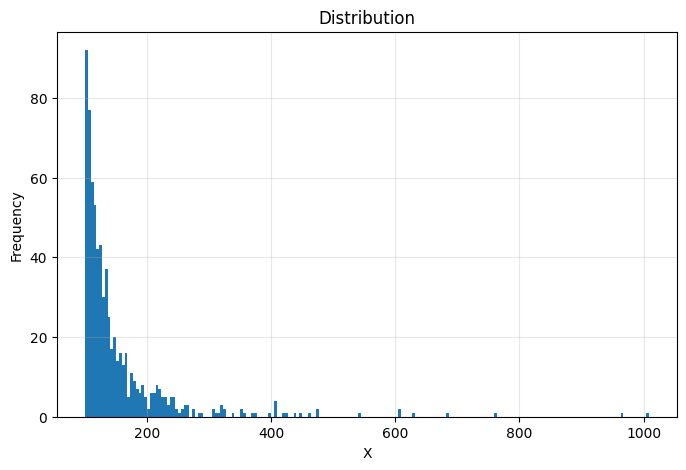

In [74]:
plot_histogram(subdurations, bins=200, figsize=(8, 5))

### Check temporal captions

In [18]:
# define some temporal prepositions
temporal_prepositions = ["after", "before", "then", "while", "during", "as soon as"]


def check_in_caption(caption, keywords):
    """Checks if any of the given keywords occur in the caption."""
    caption = caption.lower()
    for word in keywords:
        if word.lower() in caption:
            return True
    return False

In [22]:
captions = [x for x in tqdm(captions, desc="Filtering captions") if isinstance(x, str)]

In [24]:
# find captions with temporal prepositions
temporal_captions = [
    x for x in tqdm(captions, "Getting temporal captions") if check_in_caption(x, temporal_prepositions)
]

Getting temporal captions: 100%|██████████████████████████████████████████| 138429877/138429877 [02:50<00:00, 812164.23it/s]


In [25]:
temporal_captions_split = defaultdict(list)

for x in tqdm(temporal_captions, "Splitting temporal captions"):
    for word in temporal_prepositions:
        if word in x:
            temporal_captions_split[word].append(x)

Splitting temporal captions: 100%|██████████████████████████████████████████████| 134841/134841 [00:00<00:00, 459400.76it/s]


In [26]:
len(temporal_captions_split["after"])

78477

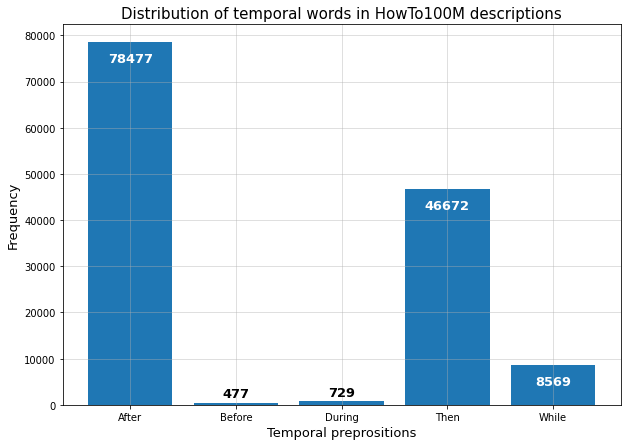

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

counts = [len(temporal_captions_split[k]) for k in temporal_captions_split]
keys = [k.capitalize() for k in temporal_captions_split]

indices = np.argsort(keys)
counts = np.array(counts)[indices]
keys = np.array(keys)[indices]

ax.grid(alpha=0.5)
ax.bar(keys, counts)
ax.set_title("Distribution of temporal words in HowTo100M descriptions", fontsize=15)
ax.set_xlabel("Temporal preprositions", fontsize=13)
ax.set_ylabel("Frequency", fontsize=13)

rects = ax.patches
for rect, count in zip(rects, counts):
    height = rect.get_height()
    
    if count > 1000:
        new_height = height - 5000
        color="white"
    else:
        new_height = height + 500
        color="black"
    
    ax.text(
        rect.get_x() + rect.get_width() / 2, new_height,
        count, ha="center", va="bottom", fontsize=13, color=color, weight='bold',
    )

plt.show()